#### Tools

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import xgboost as xgb
import shap


c:\Users\91800\Desktop\network-threat\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## EDA

In [3]:
df = pd.read_csv('Network_logs.csv')


In [4]:
print("Shape:", df.shape)
df.head()

Shape: (8846, 10)


,Source_IP,Destination_IP,Port,Request_Type,Protocol,Payload_Size,User_Agent,Status,Intrusion,Scan_Type
0,192.168.142.55,42.156.67.167,80,FTP,UDP,2369,curl/7.68.0,Success,0,Normal
1,53.39.165.18,94.60.242.119,135,SMTP,UDP,1536,Wget/1.20.3,Failure,1,BotAttack
2,192.168.127.91,7.10.192.3,21,SMTP,TCP,1183,Wget/1.20.3,Success,0,Normal
3,192.168.30.40,130.169.82.211,25,HTTPS,TCP,666,Mozilla/5.0,Success,0,Normal
4,192.168.43.179,35.140.102.220,22,FTP,TCP,2821,Mozilla/5.0,Success,0,Normal


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8846 entries, 0 to 8845
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Source_IP       8846 non-null   object
 1   Destination_IP  8846 non-null   object
 2   Port            8846 non-null   int64 
 3   Request_Type    8846 non-null   object
 4   Protocol        8846 non-null   object
 5   Payload_Size    8846 non-null   int64 
 6   User_Agent      8846 non-null   object
 7   Status          8846 non-null   object
 8   Intrusion       8846 non-null   int64 
 9   Scan_Type       8846 non-null   object
dtypes: int64(3), object(7)
memory usage: 691.2+ KB


In [6]:
df.isnull().sum()


Source_IP         0
Destination_IP    0
Port              0
Request_Type      0
Protocol          0
Payload_Size      0
User_Agent        0
Status            0
Intrusion         0
Scan_Type         0
dtype: int64

C:\Users\91800\AppData\Local\Temp\ipykernel_6172\265494217.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Scan_Type', data=df, palette='viridis')


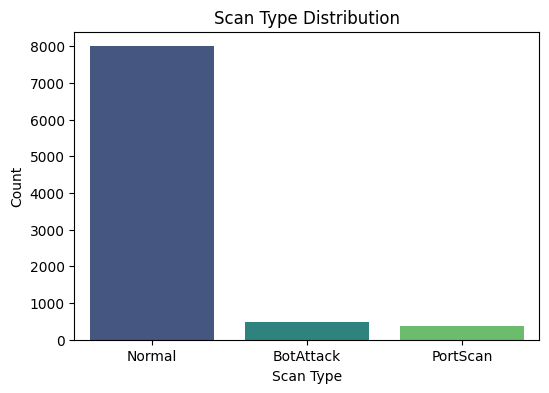

Scan_Type
Normal       0.904
BotAttack    0.054
PortScan     0.042
Name: proportion, dtype: float64


In [7]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Scan_Type', data=df, palette='viridis')
plt.title('Scan Type Distribution')
plt.xlabel('Scan Type')
plt.ylabel('Count')
plt.show()

print(df['Scan_Type'].value_counts(normalize=True).round(3))


There is a severe data imbalance in this dataset, we may consider using a certain metric data balancing techniques.

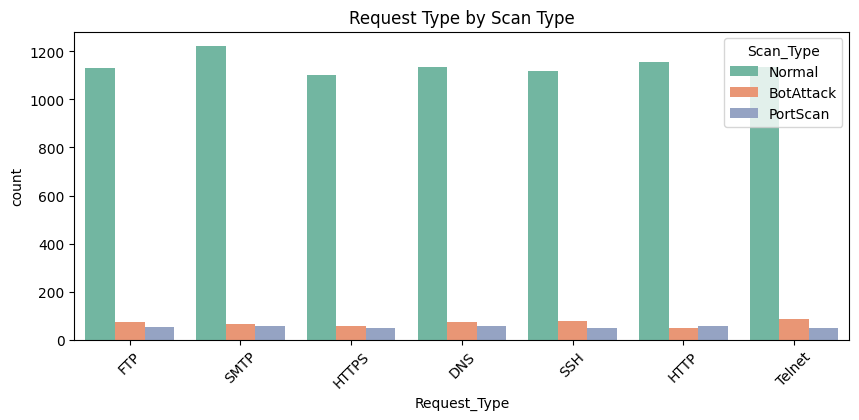

In [8]:
plt.figure(figsize=(10, 4))
sns.countplot(x='Request_Type', hue='Scan_Type', data=df, palette='Set2')
plt.title('Request Type by Scan Type')
plt.xticks(rotation=45)
plt.show()


The scan_type distribution aginst request_type is semi-balanced, there is no certain request type that guarntee a bot attack.

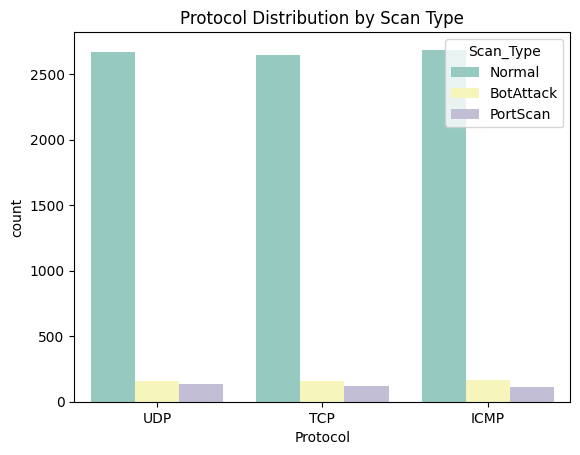

In [9]:
sns.countplot(x='Protocol', hue='Scan_Type', data=df, palette='Set3')
plt.title('Protocol Distribution by Scan Type')
plt.show()


Same Conclusion As Above.

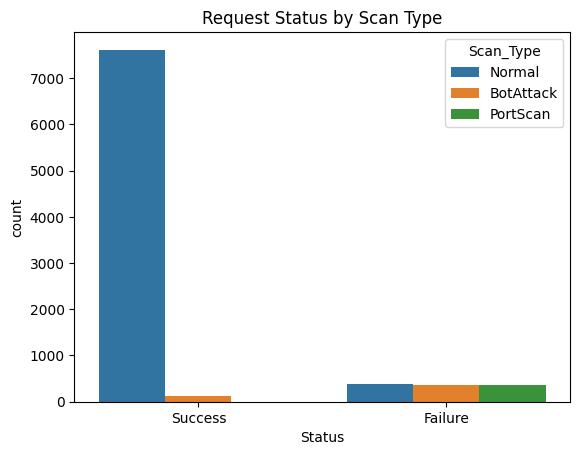

In [10]:
sns.countplot(x='Status', hue='Scan_Type', data=df)
plt.title('Request Status by Scan Type')
plt.show()


Most Normal requests are successful, while BotAttack and PortScan requests often fail. This suggests that the Status feature can help distinguish between normal and malicious traffic.

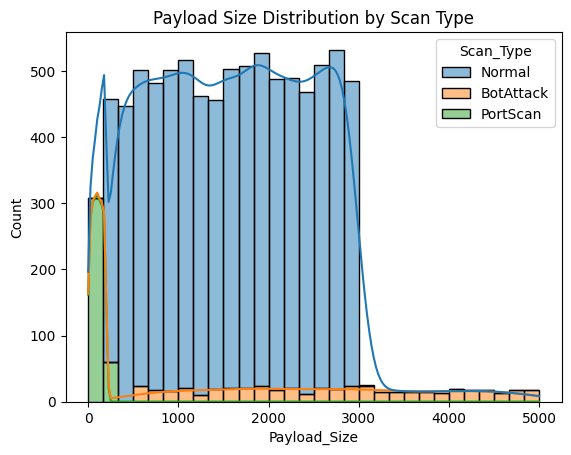

In [11]:
sns.histplot(data=df, x='Payload_Size', hue='Scan_Type', bins=30, kde=True, multiple='stack')
plt.title('Payload Size Distribution by Scan Type')
plt.show()


Normal traffic has a wide range of payload sizes, while BotAttack are mostly  big payloads. and PortScan payloads are limited to samll sizes, This suggests that payload size is a strong feature for distinguishing malicious activity.

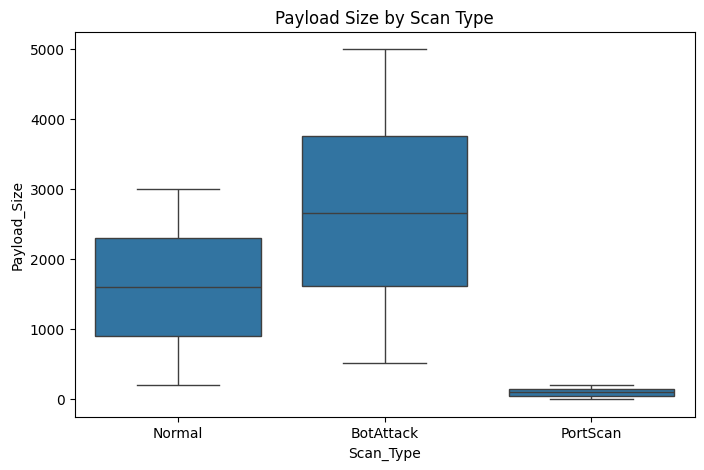

In [12]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='Scan_Type', y='Payload_Size', data=df)
plt.title('Payload Size by Scan Type')
plt.show()


Same conclusions as before.

In [13]:
top_sources = df['Source_IP'].value_counts().head(10)
top_dest = df['Destination_IP'].value_counts().head(10)

print("Top 10 Source IPs:")
print(top_sources)

print("\nTop 10 Destination IPs:")
print(top_dest)


Top 10 Source IPs:
Source_IP
33.5.52.172        58
154.113.2.100      57
95.139.88.51       57
78.199.98.120      56
197.134.233.238    54
94.40.34.8         48
216.181.134.4      46
201.232.85.16      46
161.77.134.239     45
219.110.174.163    44
Name: count, dtype: int64

Top 10 Destination IPs:
Destination_IP
168.101.218.238    1
42.156.67.167      1
94.60.242.119      1
7.10.192.3         1
130.169.82.211     1
35.140.102.220     1
1.236.8.103        1
88.97.46.184       1
210.58.142.213     1
212.23.68.106      1
Name: count, dtype: int64


We won't take into account the ip sources, since it is not a very refelctive and can not be generalized.

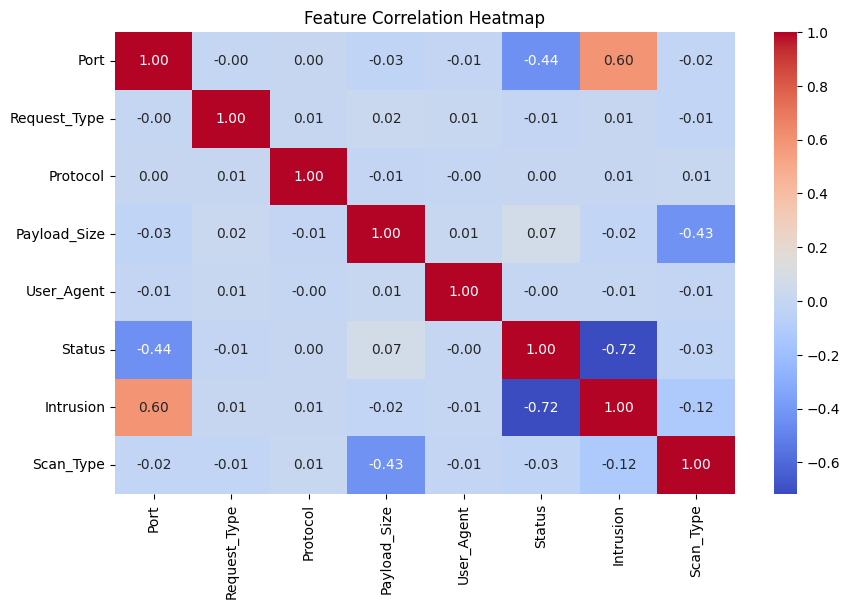

In [14]:
df_encoded = df.copy()

# Encode categoricals
for col in ['Request_Type', 'Protocol', 'User_Agent', 'Status', 'Scan_Type']:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

# Drop IPs for now
df_encoded = df_encoded.drop(['Source_IP', 'Destination_IP'], axis=1)

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()


There is no any strong colinearity between any two features, so we can proceed to the next step without droping any features.

## Data preparation

In [15]:
df

,Source_IP,Destination_IP,Port,Request_Type,Protocol,Payload_Size,User_Agent,Status,Intrusion,Scan_Type
0,192.168.142.55,42.156.67.167,80,FTP,UDP,2369,curl/7.68.0,Success,0,Normal
1,53.39.165.18,94.60.242.119,135,SMTP,UDP,1536,Wget/1.20.3,Failure,1,BotAttack
2,192.168.127.91,7.10.192.3,21,SMTP,TCP,1183,Wget/1.20.3,Success,0,Normal
3,192.168.30.40,130.169.82.211,25,HTTPS,TCP,666,Mozilla/5.0,Success,0,Normal
4,192.168.43.179,35.140.102.220,22,FTP,TCP,2821,Mozilla/5.0,Success,0,Normal
...,...,...,...,...,...,...,...,...,...,...
8841,192.168.62.111,217.201.54.87,22,DNS,UDP,651,python-requests/2.25.1,Failure,0,Normal
8842,192.168.154.70,11.93.131.139,22,Telnet,ICMP,592,Nikto/2.1.6,Success,0,Normal
8843,192.168.199.211,213.172.225.26,443,DNS,TCP,518,nmap/7.80,Success,0,Normal
8844,192.168.107.115,194.38.119.179,53,SSH,TCP,1149,Mozilla/5.0,Success,0,Normal


Drop irrelevant or high-cardinality features

In [16]:
df.drop(['Source_IP', 'Destination_IP'], axis=1, inplace=True)


Convert categorical_cols into int columns using LabelEncoder

In [17]:
categorical_cols = ['Request_Type', 'Protocol', 'User_Agent', 'Status', 'Port']
for col in categorical_cols:
    df[col] = df[col].astype('category')


Show encoded category values

In [18]:
for col in categorical_cols:
    print(f"{col} categories: {df[col].cat.categories.tolist()}")

Request_Type categories: ['DNS', 'FTP', 'HTTP', 'HTTPS', 'SMTP', 'SSH', 'Telnet']
Protocol categories: ['ICMP', 'TCP', 'UDP']
User_Agent categories: ['Mozilla/5.0', 'Nikto/2.1.6', 'Wget/1.20.3', 'curl/7.68.0', 'nmap/7.80', 'python-requests/2.25.1']
Status categories: ['Failure', 'Success']
Port categories: [21, 22, 23, 25, 53, 80, 135, 443, 4444, 6667, 8080, 31337]


In [19]:
for col in categorical_cols:
    df[col] = df[col].cat.codes

Encode target label

In [20]:
target_encoder = LabelEncoder()
df['Scan_Type_Label'] = target_encoder.fit_transform(df['Scan_Type'])

In [21]:
label_mapping = dict(zip(target_encoder.classes_, target_encoder.transform(target_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'BotAttack': np.int64(0), 'Normal': np.int64(1), 'PortScan': np.int64(2)}


In [22]:
df.drop(['Scan_Type'], axis=1, inplace=True)

In [23]:
df

,Port,Request_Type,Protocol,Payload_Size,User_Agent,Status,Intrusion,Scan_Type_Label
0,5,1,2,2369,3,1,0,1
1,6,4,2,1536,2,0,1,0
2,0,4,1,1183,2,1,0,1
3,3,3,1,666,0,1,0,1
4,1,1,1,2821,0,1,0,1
...,...,...,...,...,...,...,...,...
8841,1,0,2,651,5,0,0,1
8842,1,6,0,592,1,1,0,1
8843,7,0,1,518,4,1,0,1
8844,4,5,1,1149,0,1,0,1


Scale the payload size feautre

In [52]:
scaler = StandardScaler()
df['Payload_Size'] = scaler.fit_transform(df[['Payload_Size']])

In [25]:
df

,Port,Request_Type,Protocol,Payload_Size,User_Agent,Status,Intrusion,Scan_Type_Label
0,5,1,2,0.841271,3,1,0,1
1,6,4,2,-0.068551,2,0,1,0
2,0,4,1,-0.454106,2,1,0,1
3,3,3,1,-1.018786,0,1,0,1
4,1,1,1,1.334957,0,1,0,1
...,...,...,...,...,...,...,...,...
8841,1,0,2,-1.035169,5,0,0,1
8842,1,6,0,-1.099610,1,1,0,1
8843,7,0,1,-1.180435,4,1,0,1
8844,4,5,1,-0.491242,0,1,0,1


I previously tested the model and found that the Intrusion feature had a very high SHAP value. The model also achieved 100% accuracy, which may indicate overfitting. To encourage better generalization, we could consider dropping this feature.

In [26]:
X = df.drop(['Scan_Type_Label', 'Intrusion'], axis=1)
y = df['Scan_Type_Label']


Split the data

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [28]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (6192, 6)
Test shape: (2654, 6)


In [53]:
print(X_train)

      Port  Request_Type  Protocol  Payload_Size  User_Agent  Status
6201     0             0         2     -0.061998           1       1
386      5             1         2     -1.406525           4       1
6763     0             5         2     -0.021585           3       1
8272     3             6         0      0.632657           4       1
7671     3             3         0      0.643579           5       1
...    ...           ...       ...           ...         ...     ...
5055     7             2         0     -0.011755           2       1
3558     7             4         2      0.546371           3       1
153      4             3         0      0.451347           3       1
5494     2             6         0     -1.615140           0       0
3467     0             6         0      0.177199           1       1

[6192 rows x 6 columns]


## Model Selection

In [54]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'MLP': MLPClassifier(max_iter=500)
}


Test all the models and show SHAP graph for each model

In [55]:
sample_idx = np.random.choice(X_test.index, size=min(200, len(X_test)), replace=False)
X_sample = X_test.loc[sample_idx]


🔍 Training Logistic Regression...
✅ Accuracy: 0.9748
              precision    recall  f1-score   support

           0       0.89      0.70      0.78       144
           1       0.98      0.99      0.99      2400
           2       0.90      1.00      0.95       110

    accuracy                           0.97      2654
   macro avg       0.92      0.90      0.91      2654
weighted avg       0.97      0.97      0.97      2654

📊 SHAP Explanation for Logistic Regression


100%|██████████| 200/200 [00:00<00:00, 213.57it/s]


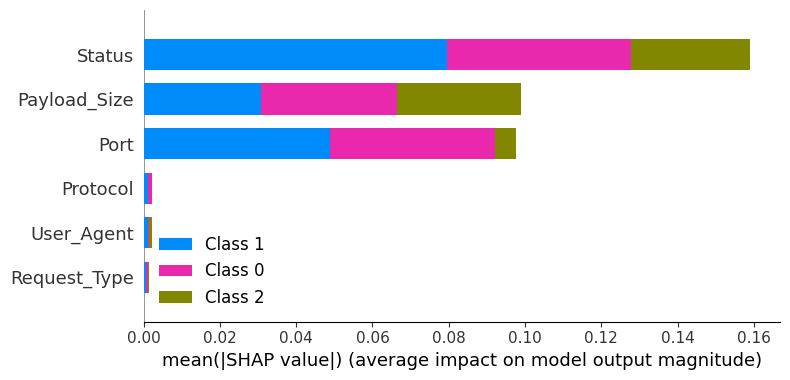


🔍 Training KNN...
✅ Accuracy: 0.9744
              precision    recall  f1-score   support

           0       0.98      0.58      0.73       144
           1       0.98      1.00      0.99      2400
           2       0.90      0.94      0.92       110

    accuracy                           0.97      2654
   macro avg       0.95      0.84      0.88      2654
weighted avg       0.97      0.97      0.97      2654

📊 SHAP Explanation for KNN


100%|██████████| 200/200 [00:09<00:00, 21.78it/s]


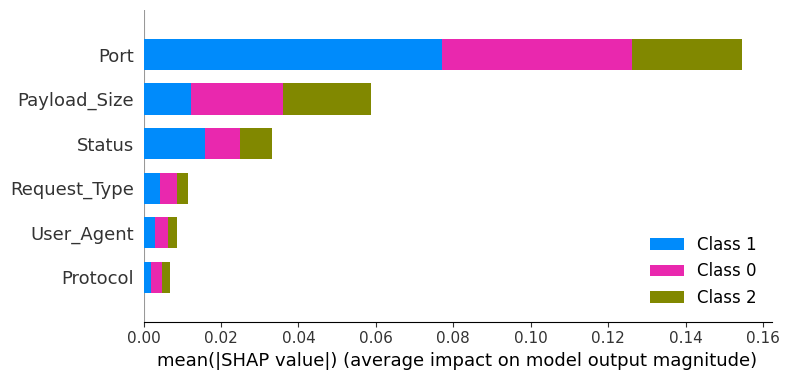


🔍 Training Decision Tree...
✅ Accuracy: 0.9992
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       144
           1       1.00      1.00      1.00      2400
           2       1.00      1.00      1.00       110

    accuracy                           1.00      2654
   macro avg       1.00      1.00      1.00      2654
weighted avg       1.00      1.00      1.00      2654

📊 SHAP Explanation for Decision Tree


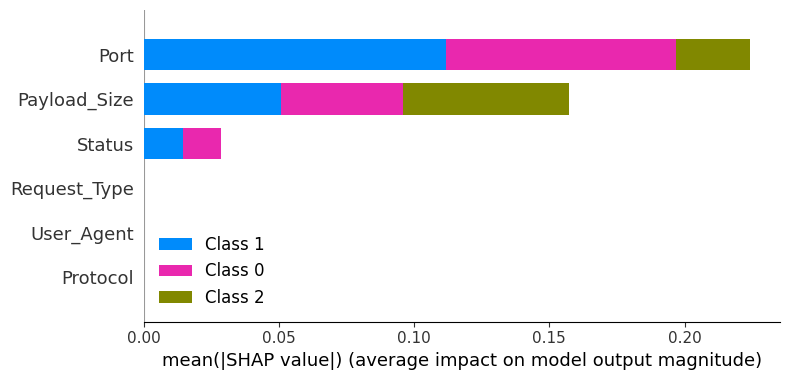


🔍 Training Random Forest...
✅ Accuracy: 0.9989
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       144
           1       1.00      1.00      1.00      2400
           2       0.99      1.00      1.00       110

    accuracy                           1.00      2654
   macro avg       1.00      1.00      1.00      2654
weighted avg       1.00      1.00      1.00      2654

📊 SHAP Explanation for Random Forest


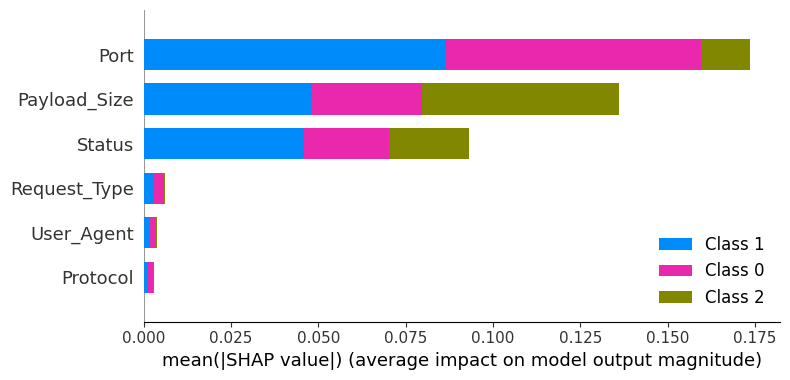


🔍 Training XGBoost...
✅ Accuracy: 0.9992
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       144
           1       1.00      1.00      1.00      2400
           2       0.99      1.00      1.00       110

    accuracy                           1.00      2654
   macro avg       1.00      1.00      1.00      2654
weighted avg       1.00      1.00      1.00      2654

📊 SHAP Explanation for XGBoost


c:\Users\91800\Desktop\network-threat\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [02:39:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


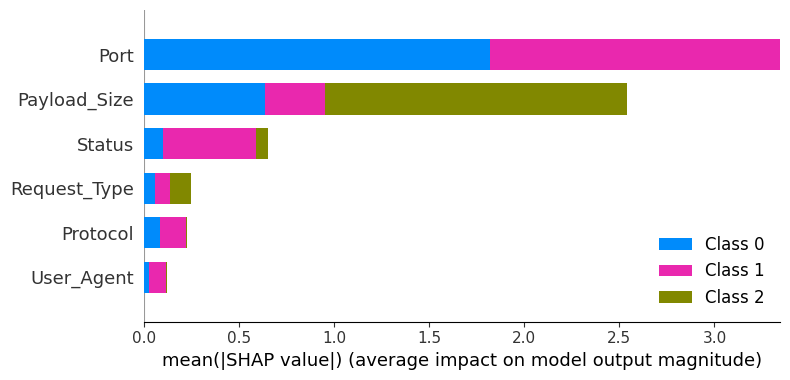


🔍 Training MLP...
✅ Accuracy: 0.9868
              precision    recall  f1-score   support

           0       0.94      0.87      0.90       144
           1       0.99      0.99      0.99      2400
           2       0.93      1.00      0.96       110

    accuracy                           0.99      2654
   macro avg       0.95      0.95      0.95      2654
weighted avg       0.99      0.99      0.99      2654

📊 SHAP Explanation for MLP


100%|██████████| 200/200 [00:02<00:00, 91.09it/s]


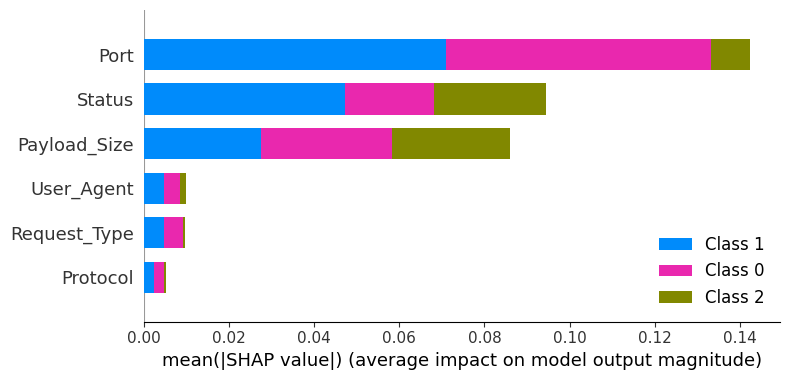

In [56]:
for name, model in models.items():
    print(f"\n🔍 Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    print(f"✅ Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

    # SHAP explanation
    print(f"📊 SHAP Explanation for {name}")
    
    # Tree-based models use TreeExplainer
    if name in ['Random Forest', 'XGBoost', 'Decision Tree']:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_sample)
        shap.summary_plot(shap_values, X_sample, plot_type="bar", show=True)
    
    # Model-agnostic SHAP (slow, so sample used)
    else:
        # Convert model to function for KernelExplainer
        explainer = shap.KernelExplainer(model.predict_proba, X_train.iloc[:100])
        shap_values = explainer.shap_values(X_sample)
        shap.summary_plot(shap_values, X_sample, plot_type="bar", show=True)


Since all models performed exceptionally well on the test dataset, I'll proceed with the Decision Tree model for the final evaluation.

## Model Training

In [57]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

## Model Testing

Predict on the test set

In [58]:
y_pred = dt_model.predict(X_test)

In [59]:
report = classification_report(y_test, y_pred, output_dict=False)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       144
           1       1.00      1.00      1.00      2400
           2       1.00      1.00      1.00       110

    accuracy                           1.00      2654
   macro avg       1.00      1.00      1.00      2654
weighted avg       1.00      1.00      1.00      2654



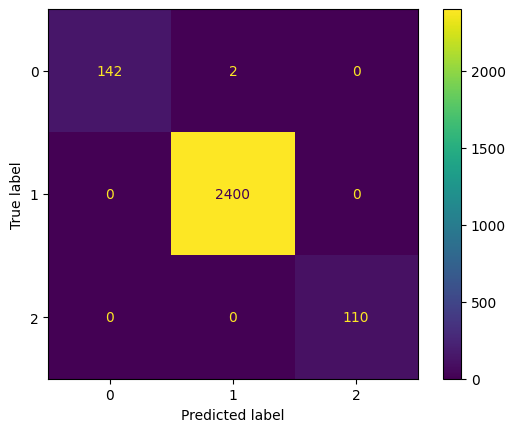

In [60]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model.classes_)
disp.plot()


## Save the model

In [63]:
import joblib
joblib.dump(dt_model, 'network_logs_decision_tree_model.joblib')


['network_logs_decision_tree_model.joblib']

In [64]:
joblib.dump(scaler, 'scaler_payload.joblib')

['scaler_payload.joblib']

In [49]:
print(X.columns)  # X is your training features DataFrame


Index(['Port', 'Payload_Size', 'Request_Type', 'Protocol', 'User_Agent',
       'Status', 'Source_IP', 'Destination_IP'],
      dtype='object')


In [50]:
print(model.feature_names_in_)  # This works for scikit-learn 1.0+


['Port' 'Request_Type' 'Protocol' 'Payload_Size' 'User_Agent' 'Status']


In [65]:
joblib.dump(scaler, 'payload_scaler.joblib')

['payload_scaler.joblib']